# Using delay_dist = True 

By default PyROA assumes a single level of blurring for all lightcurves being modelled given by $\Delta$, essentially meaning there is a single delay between lightcurves i.e a dirac delta delay distribution. To generalise from this, we convolve the ROA Gaussian window of width, $\Delta$, with the delay distribution relative to a given lightcurve. The reference lightcurve just has the original window function whereas the others this has been convolved with the model transfer function. We use a numerical convolution, allowing for a variety of different transfer function, which can be different for each lightcurve if needed.

Now the $\tau$ parameters represent the mean delay and new parameters - $\Delta_{i}$ are the rms of the delay distribution around this mean.

To enable in the code use delay_dist = True in the Fit() function. By default the transfer function is a Gaussian, which in this special case the convolution is analytical. Below this is ran for some mock data. The first lightcurve in the "Filters" array is the reference for the blurring. A seperate lightcurve can still be the reference for the mean delay parameter, $\tau$, using the delay_ref argument of Fit().

In [5]:
import PyROA
datadir = "/home/fergus/Documents/GitHub/Blurred/"
objName="TestObj"
filters=["1","2"]
    
priors = [[0.5, 2.0],[0.5, 2.0], [-50.0, 50.0], [0.01, 10.0], [0.0, 10.0]]

fit = PyROA.Fit(datadir, objName, filters, priors, Nsamples = 15000, Nburnin = 10000, add_var=True, delay_dist = True)

Initial Parameter Values
     A0       B0    σ0       A1       B1    τ1    Δ1    σ1    Δ
-------  -------  ----  -------  -------  ----  ----  ----  ---
9.65495  81.4652  0.01  1.61029  89.6219     1     1  0.01    1
NWalkers=22


100%|██████████| 15000/15000 [04:51<00:00, 51.43it/s]


Filter: 1
Mean Delay, error: 0.00 (fixed)
Filter: 2
Mean Delay, error:    4.95745  (+   0.02893 -   0.02938)


Best Fit Parameters
     A0       B0        σ0      A1       B1       τ1      Δ1         σ1         Δ
-------  -------  --------  ------  -------  -------  ------  ---------  --------
9.62695  81.4582  0.257961  1.6012  89.6249  4.95745  1.5963  0.0883658  0.517571


/home/fergus/Documents/GitHub/PyROA3.py:39: RuntimeWarning: invalid value encountered in true_divide
  return np.exp(-0.5*((t-mean)/sig)**2)


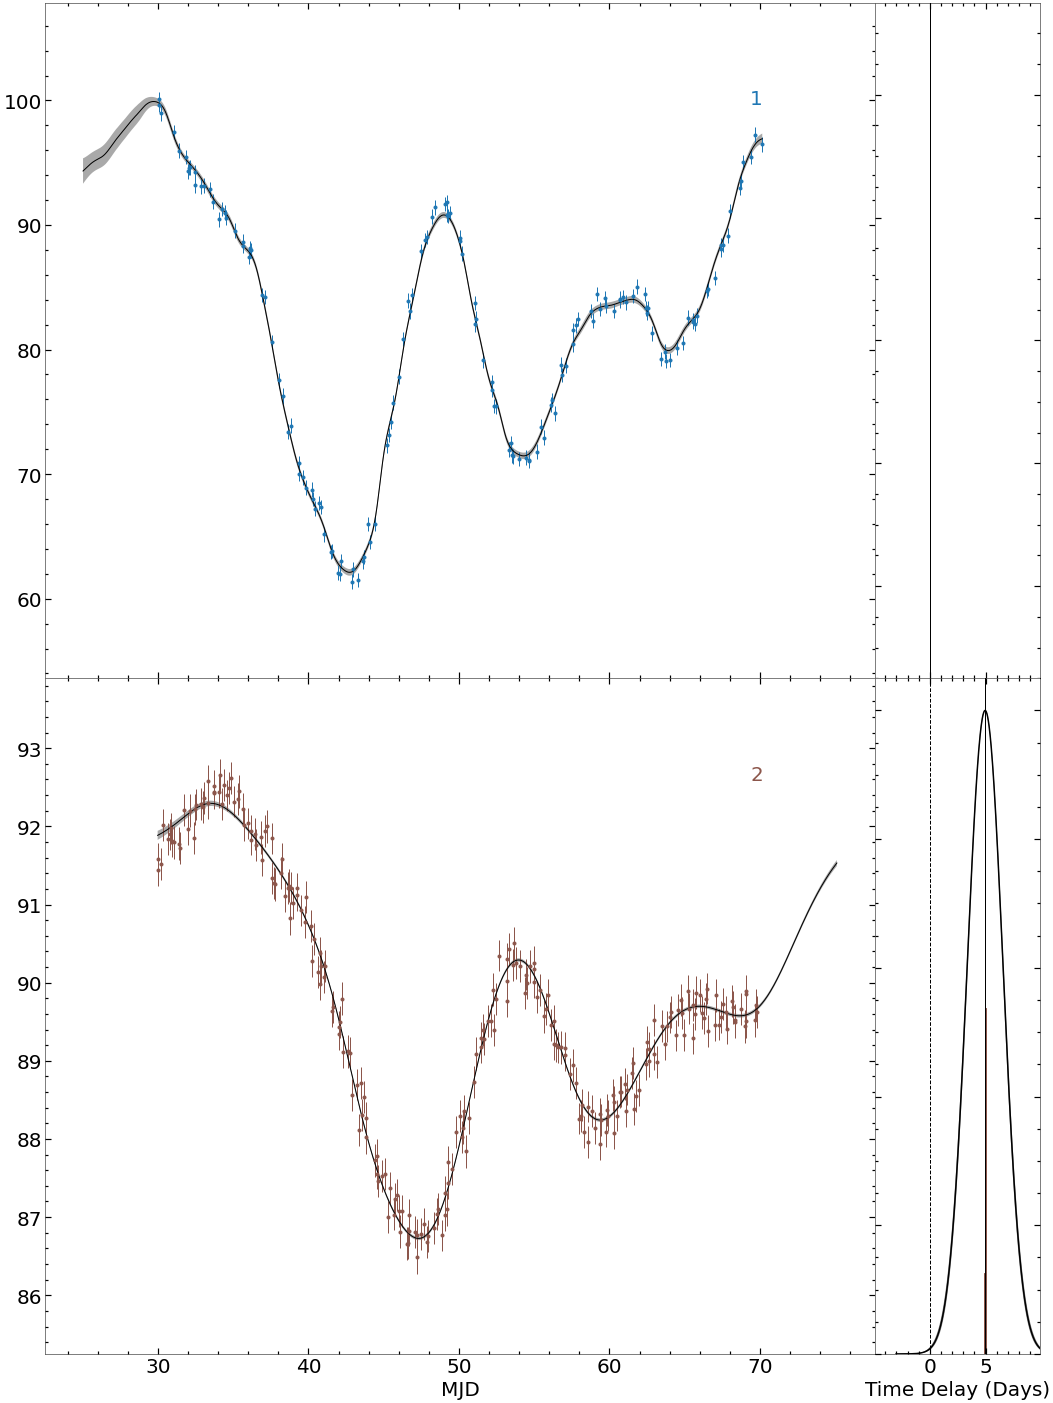

In [6]:
PyROA.Plot(fit)

The above case is simple but likely atypical. The above used a Gaussian transfer function which allows delays from $-\infty$ to $\infty$ which breaks causality. This is similarly the case if using a uniform transfer function here. To impose causality we can use a log-Gaussian delay distribution, which prevents any delays less than that of the blurring reference lightcurve. To specify this we use the array psi_types = [], where the type of delay distribution for each of the non-reference lightcurves are specified. The options are:
- "Gaussian"
- "Uniform"
- "LogGaussian"
- "InverseGauss" - This acts very similarly to the log-gauss
- "TruncGaussian" - Truncated at the minimum delay - we have had some issues with this biasing the mean delay.


More can be added in the future fairly easily. Below runs this for a log-Gaussian transfer function with some other mock data - this was generated from CREAM and thus represents a typical disc RM scenario.

In [1]:
import PyROA
datadir = "/home/fergus/Documents/GitHub/CREAMSynthetic/"
objName="lc"
filters=["1","2", "3"]
    
priors = [[0.5, 2.0],[0.5, 2.0], [-50.0, 50.0], [0.01, 10.0], [0.0, 50.0]]
psi_types = ["LogGaussian", "LogGaussian"]
fit = PyROA.Fit(datadir, objName, filters, priors, Nsamples = 20000, Nburnin = 15000, add_var=True, delay_dist = True, psi_types = psi_types)

Initial Parameter Values
     A0       B0    σ0       A1       B1    τ1    Δ1    σ1       A2       B2    τ2    Δ2    σ2    Δ
-------  -------  ----  -------  -------  ----  ----  ----  -------  -------  ----  ----  ----  ---
37.8558  491.376  0.01  37.0235  453.912     1     1  0.01  34.5411  442.202     1     1  0.01    1
NWalkers=32


100%|██████████| 20000/20000 [57:58<00:00,  5.75it/s]


Filter: 1
Mean Delay, error: 0.00 (fixed)
Filter: 2
Mean Delay, error:    0.65801  (+   0.07846 -   0.08010)
Filter: 3
Mean Delay, error:    0.73619  (+   0.07878 -   0.07771)


Best Fit Parameters
     A0       B0      σ0       A1       B1        τ1        Δ1        σ1       A2       B2        τ2        Δ2        σ2        Δ
-------  -------  ------  -------  -------  --------  --------  --------  -------  -------  --------  --------  --------  -------
37.2241  491.145  3.6306  36.5077  453.931  0.658013  0.301196  0.613805  34.1555  442.235  0.736188  0.459908  0.784255  1.45182


/home/fergus/Documents/GitHub/PyROA3.py:69: RuntimeWarning: invalid value encountered in double_scalars
  mu = np.log(mean**2/np.sqrt(mean**2 + sig**2))
/home/fergus/Documents/GitHub/PyROA3.py:70: RuntimeWarning: invalid value encountered in double_scalars
  stddev2 = np.log( 1.0+ (sig**2)/(mean**2))


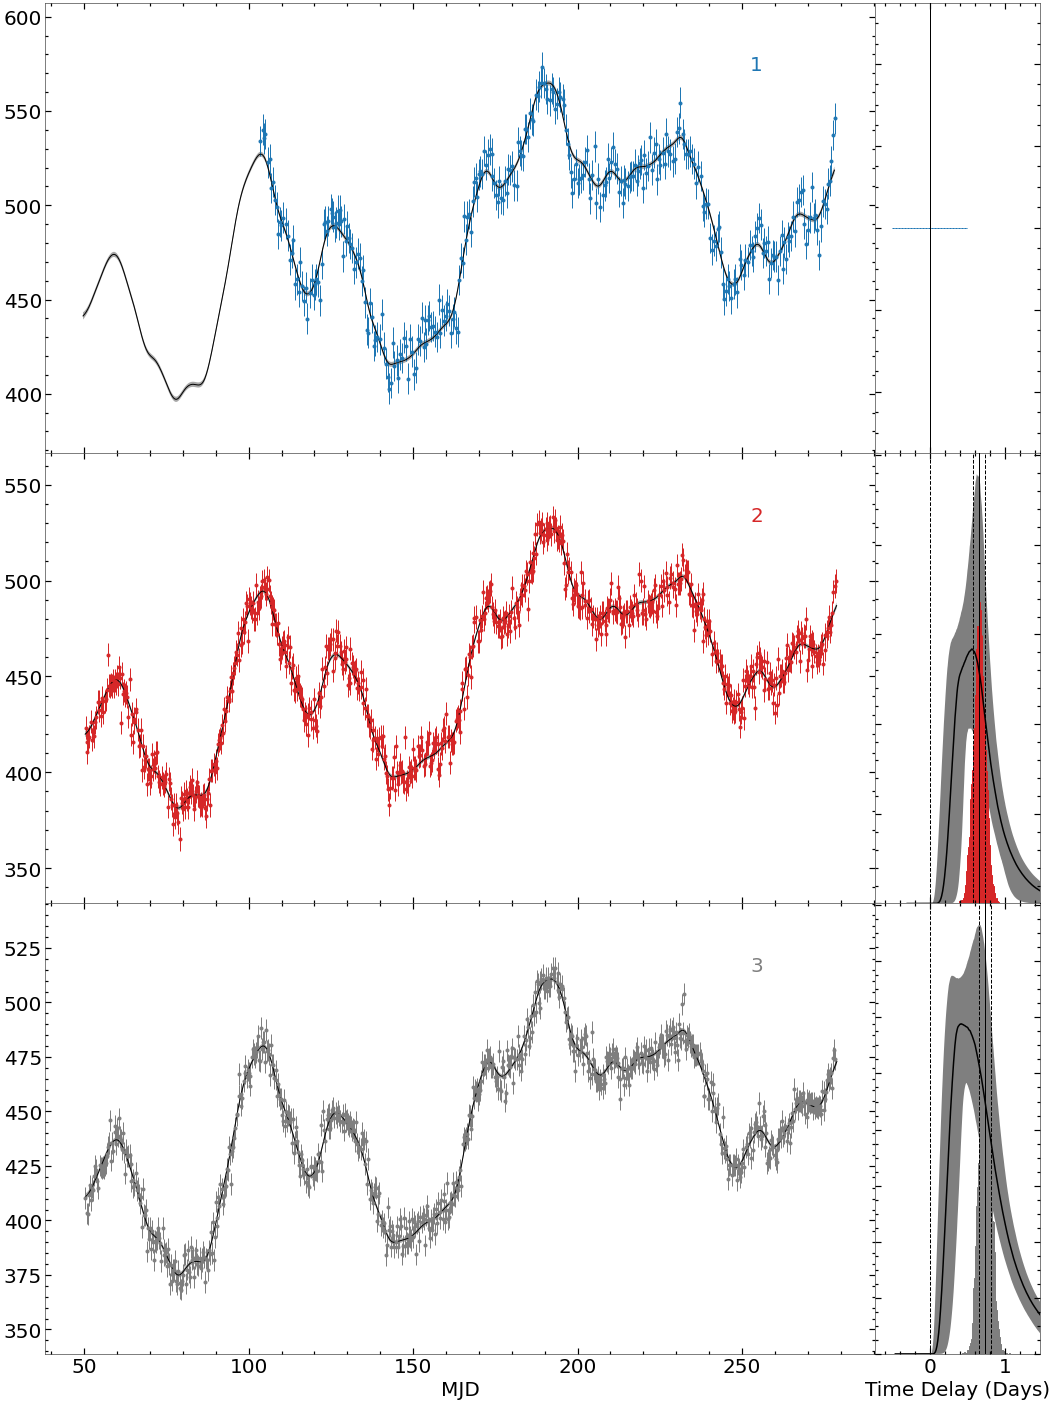

In [2]:
PyROA.Plot(fit)

There is also an untested implementaion of a face-on accretion disc model. As PyROA can only measure the blurring relative to the first lightcurve, the transfer function used here is calculated using the difference in wavelength from the modelled lightcurve to the reference - I'm not sure if this is correct and needs tested. Here the temperature at 1 light day, $T_1$ and the temperature profile power, $\beta$, are sampled instead of delays and rms's. 

This implemetation also doesn't do the full integral per sample as of yet (unlike CREAM), and so the power parameter is best left fixed at 0.75.

To run this use AccDisc=True and provide the wavelengths of each filter. The priors are for $A_i$, $B_i$, $\sigma_i$, $T_1$, $\beta$, $\Delta$.

The delays here seem much shorter so probably the wrong implementation - but the fit looks good.

In [3]:
import PyROA
import numpy as np
datadir = "/home/fergus/Documents/GitHub/CREAMSynthetic/"
objName="lc"
filters=["1","2", "3"]
    
priors= [[0.5, 2.0],[0.5, 2.0], [0.0, 50.0], [1.0e3, 1.0e5],[0.749, 0.751],[0.1, 10.0]] # Use small range for beta to fix power law to -3/4
wavelengths = np.array([4152.5, 5917.9, 8284.1])
fit = PyROA.Fit(datadir, objName, filters, priors, Nsamples = 20000, Nburnin = 15000, add_var=True, AccDisc = True, wavelengths = wavelengths)

/home/fergus/Documents/GitHub/PyROA3.py:589: RuntimeWarning: overflow encountered in cosh
  return (x**(4 - 1/b))/(np.cosh(x)-1.0)
/home/fergus/Documents/GitHub/PyROA3.py:1194: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  Is.append(quad(integrand, 0, np.inf, args=(bs[i]))[0])
/home/fergus/Documents/GitHub/PyROA3.py:589: RuntimeWarning: divide by zero encountered in double_scalars
  return (x**(4 - 1/b))/(np.cosh(x)-1.0)
/home/fergus/Documents/GitHub/PyROA3.py:591: RuntimeWarning: overflow encountered in cosh
  return (x**(4 + 1/b))/(np.cosh(x)-1.0)


Initial Parameter Values
     A0       B0    σ0       A1       B1    σ1       A2       B2    σ2     T1     β    Δ
-------  -------  ----  -------  -------  ----  -------  -------  ----  -----  ----  ---
37.8558  491.376  0.01  37.0235  453.912  0.01  34.5411  442.202  0.01  10000  0.75    1
NWalkers=24


100%|██████████| 20000/20000 [41:46<00:00,  7.98it/s]


Filter: 1
Mean Delay, error: 0.00 (fixed)
Filter: 2
Mean Delay, error:    0.12661  (+   0.01918 -   0.01782)
Filter: 3
Mean Delay, error:    0.39343  (+   0.05975 -   0.05534)


Best Fit Parameters
     A0       B0       σ0       A1       B1        σ1       A2       B2        σ2       T1         β
-------  -------  -------  -------  -------  --------  -------  -------  --------  -------  --------
37.1728  491.191  4.02502  36.4941  453.923  0.755891  34.1599  442.221  0.788939  5148.65  0.749953


/home/fergus/Documents/GitHub/PyROA3.py:589: RuntimeWarning: overflow encountered in cosh
  return (x**(4 - 1/b))/(np.cosh(x)-1.0)
/home/fergus/Documents/GitHub/PyROA3.py:1774: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  Is.append(quad(integrand, 0, np.inf, args=(bs[i]))[0])
/home/fergus/Documents/GitHub/PyROA3.py:589: RuntimeWarning: divide by zero encountered in double_scalars
  return (x**(4 - 1/b))/(np.cosh(x)-1.0)
/home/fergus/Documents/GitHub/PyROA3.py:591: RuntimeWarning: overflow encountered in cosh
  return (x**(4 + 1/b))/(np.cosh(x)-1.0)
/home/fergus/Documents/GitHub/PyROA3.py:137: RuntimeWarning: invalid value encountered in power
  x = (l_0/l)*((t/tau_0)**b)
/home/fergus/Documents/GitHub/PyROA3.py:137: RuntimeWarning: invalid value encountered in power
  

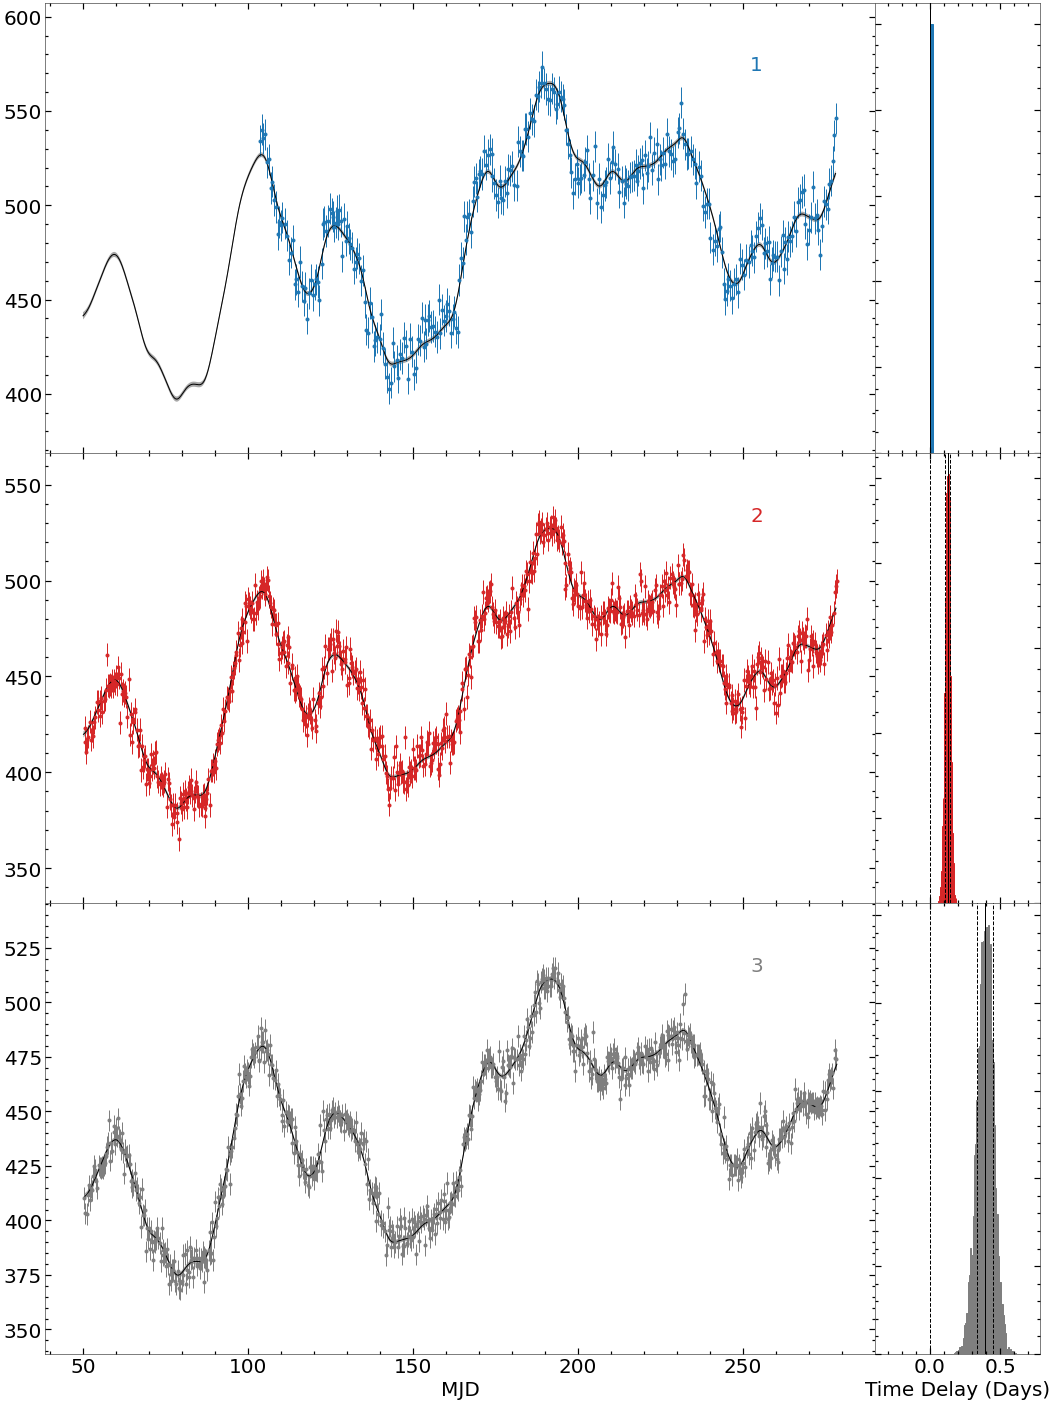

In [4]:
PyROA.Plot(fit)